# Subdivide Problem

In [1]:
# Basic
from IPython.display import display, Math
import warnings
warnings.filterwarnings('ignore')

# Statistics
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from scipy.stats import chi2_contingency, norm, skew, kurtosis

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from sklearn.model_selection import cross_val_score

# Modelling
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.linear_model import ElasticNet, SGDRegressor, Ridge, Lasso, BayesianRidge, LassoLarsIC
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb

# Model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
# Colab
train_url = "https://raw.githubusercontent.com/davidmiller2013/207-project-home-price/main/data/train.csv"
test_url = "https://raw.githubusercontent.com/davidmiller2013/207-project-home-price/main/data/test.csv"
house_train = pd.read_csv(train_url)
house_test = pd.read_csv(test_url)

# Local
# house_train = pd.read_csv('../data/train.csv')
# house_test = pd.read_csv('../data/test.csv')

### Handle Missing Data

In [57]:
def missing_ratio(df):
    '''Calculate % of observations with a NaN value for each column of a df'''
    data_na = (df.isnull().sum() / len(df)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index)\
                     .sort_values(ascending=False)[:30]

    missing_data = pd.DataFrame({'Missing Ratio': data_na})
    return missing_data

missing_ratio(house_train)

,Missing Ratio
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageYrBlt,5.547945
GarageType,5.547945
GarageFinish,5.547945
GarageQual,5.547945


In [58]:
def handle_missing_data(df,
                        drop_features=None,
                        none_features=None,
                        med_features=None,
                        mode_features=None,
                        convert_features=None
                       ):
    '''
    Perform basic feature engineering as applicable to each feature / set of features.
    Includes imputation of NaN, mean normalization, and feature dropping.

    df:                the dataframe to be transformed
    drop_features:     columns that should be dorpped from the dataframe
    none_features:     columns where NaN should be replaced with None or 0
    med_features:      numeric columns where NaN should be replaced with the median value
    mode_features:     numeric columns where NaN should be replaced with the mode value
    convert_features:  numeric columns that should be converted to ordinal features
    '''
    
    df = df.drop(drop_features, axis=1)

    for feature in none_features:
        if df[feature].dtype == 'O':
            df[feature] = df[feature].fillna("None")
        else:
            df[feature] = df[feature].fillna(0)
    
    for feature in med_features:
        df[feature] = df[feature].fillna(df[feature].median()[0])
    
    for feature in mode_features:
        df[feature] = df[feature].fillna(df[feature].mode()[0])
    
    for feature in convert_features:
        df[feature] = df[feature].astype(str)
    
    return df




In [59]:
# Features to drop from df
drop_features = ['Id', 'Utilities'] # all same value except for 2 NA

# Features to replace NaN with None or 0 - logical assumption that NaN means the house does not have X feature
none_features = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'BsmtQual',
                 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType',
                 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt',
                 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea', 'MSSubClass'
                ]

# Features to fill NaN with the median value of the column
med_features = []


# Features to fill NaN with the mode value of the column
mode_features = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd',
                 'SaleType'
                ]
    
# Numeric features that are actually ordinal and should be converted
convert_features = ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold']

house_train = handle_missing_data(house_train,
                                  drop_features,
                                  none_features,
                                  med_features,
                                  mode_features,
                                  convert_features
                                 )


In [60]:
def custom_feature_engineering(df):
    '''Apply custom operations to dataframe. Contained in a function for re-use with test data'''

    # Fill NaN values for LotFrontage with median in each neighborhood
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # For Functional column, data_description.txt indicates that NaN = Typ
    df['Functional'] = df['Functional'].fillna('Typ')

    # Calculate total sqft of house as a new feature
    df['TotalSF'] = df[['TotalBsmtSF', '1stFlrSF', '2ndFlrSF']].sum(axis=1)

    return df

house_train = custom_feature_engineering(house_train)

In [61]:
# Check that there are no remaining missing values
missing_ratio(house_train)

,Missing Ratio


In [62]:
# Explore skew and kurtosis functions in pandas and scipy
pd_skew    = house_train['LotArea'].skew()
pd_kurt    = house_train['LotArea'].kurt()
sci_skew   = skew(house_train['LotArea'], bias=False)
sci_kurt   = kurtosis(house_train['LotArea'], bias=False)
sci_skew_b = skew(house_train['LotArea'], bias=True)
sci_kurt_b = kurtosis(house_train['LotArea'], bias=True)

pd.DataFrame({'skew': [pd_skew, sci_skew, sci_skew_b],
              'kurtosis': [pd_kurt, sci_kurt, sci_kurt_b]},
             index=['pandas', 'scipy-unbiased', 'scipy-biased']
            )

,skew,kurtosis
pandas,12.207688,203.243271
scipy-unbiased,12.207688,203.243271
scipy-biased,12.195142,202.543793


In [63]:
# Calculate skew and kurtosis of all numerical features
num_features = house_train.dtypes[house_train.dtypes != "object"].index
skew_features = house_train[num_features].apply(lambda x: pd.Series({'skew': x.skew(),
                                                                     'kurtosis': x.kurtosis()
                                                                    }))
skew_df = pd.DataFrame({'skew': skew_features.loc['skew'],
                        'kurtosis': skew_features.loc['kurtosis']
                       }).sort_values(by='skew', ascending=False)
skew_df

,skew,kurtosis
MiscVal,24.476794,701.003342
PoolArea,14.828374,223.268499
LotArea,12.207688,203.243271
3SsnPorch,10.304342,123.662379
LowQualFinSF,9.011341,83.234817
KitchenAbvGr,4.488397,21.532404
BsmtFinSF2,4.255261,20.113338
ScreenPorch,4.122214,18.439068
BsmtHalfBath,4.103403,16.396642
EnclosedPorch,3.089872,10.430766


In [64]:
# Apply boxcox transformation to skewed features
from scipy.special import boxcox1p
from sklearn.preprocessing import PowerTransformer


# Explore 2 methods using highly skewed feature
temp = pd.DataFrame(house_train['LotArea'])

# Take the log10 of votes
temp['LotArea_Norm'] = boxcox1p(temp['LotArea'], 0)

# Apply power transformation
pt = PowerTransformer()
temp['LotArea_Power'] = pt.fit_transform(pd.DataFrame(temp['LotArea']))


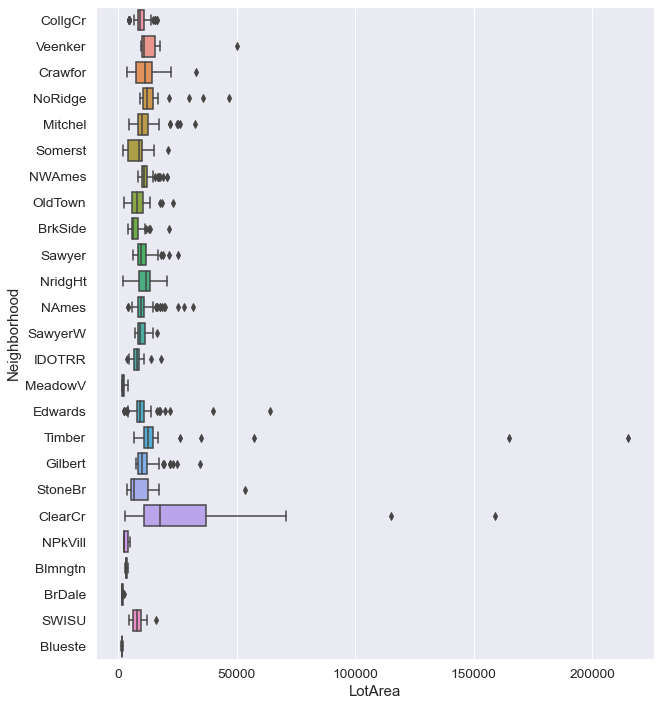

In [65]:
fig, ax = plt.subplots(figsize=(10,12))
sns.boxplot(x='LotArea', y='Neighborhood', orient='h', data=house_train)
plt.show()

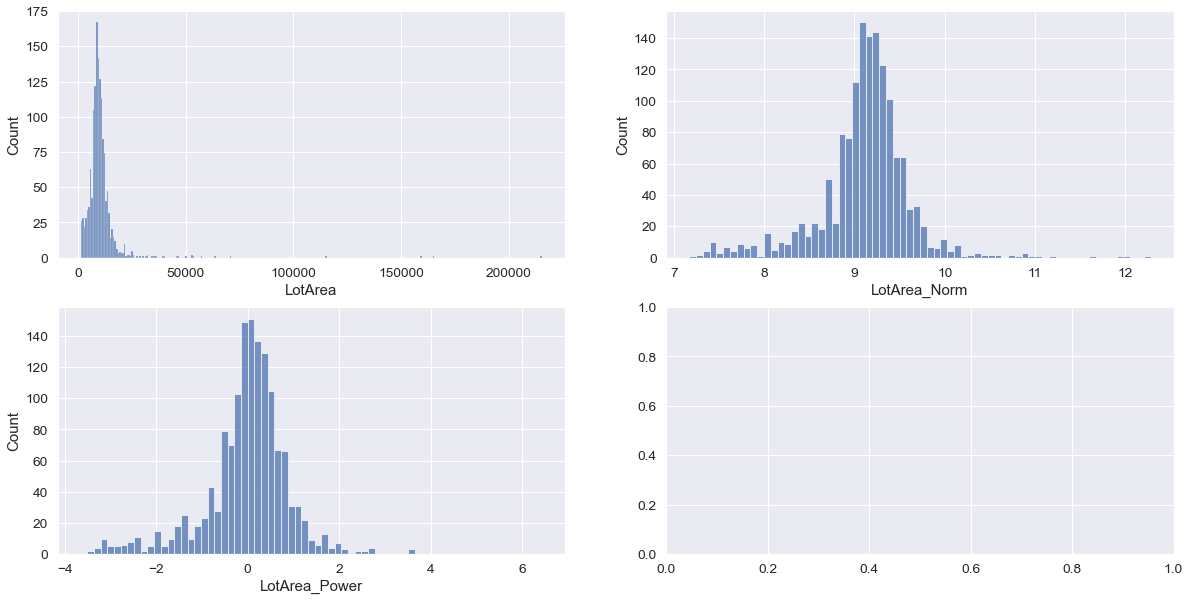

In [66]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

sns.histplot(x='LotArea',
             data=temp,
             ax=ax[0][0]
            )

sns.histplot(x='LotArea_Norm',
             data=temp,
             ax=ax[0][1]
            )

sns.histplot(x='LotArea_Power',
             data=temp,
             ax=ax[1][0]
            )

plt.show()

In [67]:
# Simple pandas function to replicate a OneHotEncoder
house_train = pd.get_dummies(house_train)

### Model Building

In [101]:
def calculate_residuals(predictions, actuals):
    residuals = actuals - predictions
    return residuals

In [121]:
def plot_residual(y_pred, y_dev, model_name='Linear Regression v1'):
    residuals = calculate_residuals(y_pred, y_dev)
    plt.scatter(y_pred, residuals)
    plt.xlabel('Predicted Value')
    plt.ylabel('Residals')
    plt.title(f"Residual Plot of {model_name}")
    plt.axhline(y=0, color='r', linestyle='-')
    plt.show()

In [103]:
# Get the data samples with the largest residuals
def get_largest_residuals(y_pred, y_dev, n=10):
    residuals = calculate_residuals(y_pred, y_dev)
    absolute_residuals = abs(residuals)
    integer_indices = np.flip(np.argsort(absolute_residuals))[:n] # top n largest residuals
    top_residuals = absolute_residuals.iloc[integer_indices]
    return X_dev.loc[top_residuals.index]

In [104]:
def get_p_values_of_difference(X_largest_residuals, X_dev):
    for column in X_largest_residuals.columns:
        p_value = ttest_ind(X_largest_residuals[column], X_dev[column])[1]
        bonferroni_threshold = 0.05 / len(X_largest_residuals.columns)
        if p_value < bonferroni_threshold:
            significance = ", Statistically significant"
        else:
            significance = ""
        print(f"{column} p-value: {round(p_value, 3)}{significance}")

In [105]:
def evaluate_model(X, y, model_type, initial_model=False):
    X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=42)
    if model_type == 'linear_regression':
        model = LinearRegression()
    if model_type == 'xgboost':
        model = xgb.XGBRegressor(colsample_bytree=0.4603,
                           gamma=0.0468, 
                           learning_rate=0.05,
                           max_depth=3, 
                           min_child_weight=1.7817,
                           n_estimators=2200,
                           reg_alpha=0.4640,
                           reg_lambda=0.8571,
                           subsample=0.5213,
                           silent=1,
                           random_state=7,
                           nthread=-1
                          )
    fitted_model = model.fit(X_train, y_train)
    r2 = fitted_model.score(X_train, y_train)

    if initial_model:
        x1, x2, x3 = fitted_model.coef_
        intercept = fitted_model.intercept_
        print("The initial model function is: y = {:.2f}x1 + {:.2f}x2 + {:.2f}x3 + {:.2f}".format(x1, x2, x3, intercept))

    model_name = ' '.join(model_type.split('_')).title()
    display(Math(r'\text{{{}}} \text{{ model performance metrics}}'.format(model_name)))

    y_pred = fitted_model.predict(X_dev)
    mae = mean_absolute_error(y_dev, y_pred)
    mse = mean_squared_error(y_dev, y_pred, squared=True)
    rmse = mean_squared_error(y_dev, y_pred, squared=False)
    

    display(Math(r'R^2 \text{{: }} {:.2f}'.format(r2)))
    display(Math(r'\text{{MAE: }} {:.2f}'.format(mae)))
    display(Math(r'\text{{MSE: }} {:.2f}'.format(mse)))
    display(Math(r'\text{{RMSE: }} {:.2f}'.format(rmse)))
    
    return X_train, X_dev, y_train, y_dev, y_pred, fitted_model

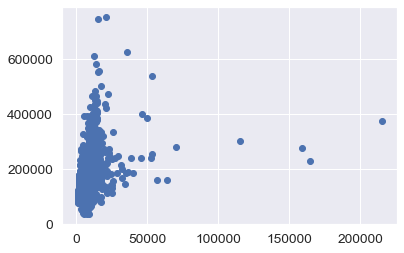

In [159]:
#Plot SalePrice vs Lot Area
plt.scatter(house_train['LotArea'],house_train['SalePrice'])
plt.show()

### EDA

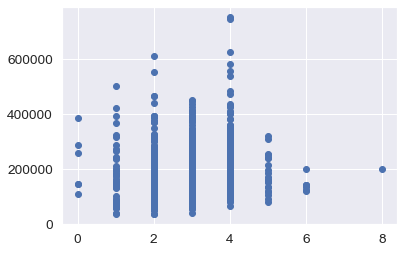

In [162]:
#Plot SalePrice vs BedroomAbvGr
plt.scatter(house_train['BedroomAbvGr'],house_train['SalePrice'])
plt.show()

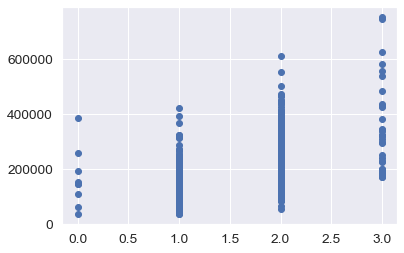

In [163]:
#Plot SalePrice vs BedroomAbvGr
plt.scatter(house_train['FullBath'],house_train['SalePrice'])
plt.show()

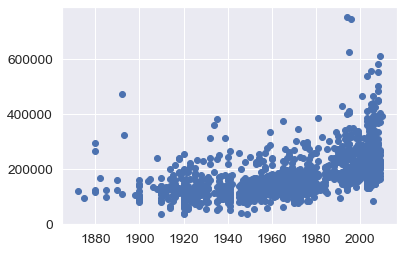

In [164]:
#Plot SalePrice vs YearBuilt
plt.scatter(house_train['YearBuilt'],house_train['SalePrice'])
plt.show()

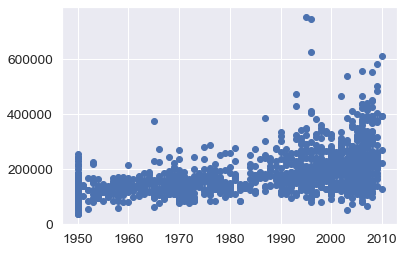

In [170]:
#Plot SalePrice vs YearRemodAdd
plt.scatter(house_train['YearRemodAdd'],house_train['SalePrice'])
plt.show()

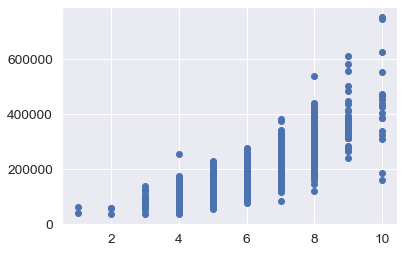

In [171]:
#Plot SalePrice vs OverallQual
plt.scatter(house_train['OverallQual'],house_train['SalePrice'])
plt.show()

### Split by SalePrice - Cheap vs Expensive

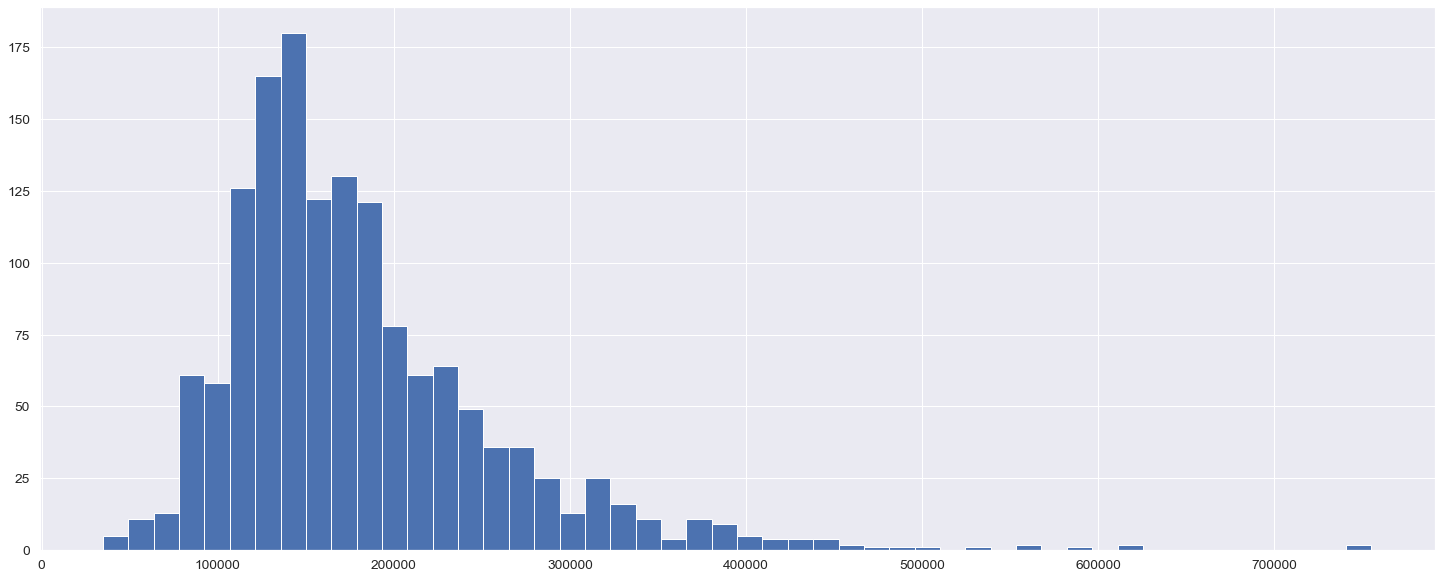

In [106]:
house_train['SalePrice'].hist(bins=50, figsize=(25, 10))
plt.show()

In [107]:
house_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [71]:
cheap_house_train = house_train[house_train['SalePrice'] < 200000]
exp_house_train = house_train[house_train['SalePrice'] >= 200000]

In [72]:
cheap_house_train['SalePrice'].describe()

count      1025.000000
mean     141060.388293
std       32860.835604
min       34900.000000
25%      119500.000000
50%      141000.000000
75%      167900.000000
max      199900.000000
Name: SalePrice, dtype: float64

In [73]:
exp_house_train['SalePrice'].describe()

count       435.000000
mean     274846.087356
std       77934.668222
min      200000.000000
25%      223250.000000
50%      250000.000000
75%      305450.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [165]:
#Model based on domain knowledge - Cheap Houses
initial_features = ['LotArea', 'YearBuilt', 'OverallQual']

X, y = cheap_house_train[initial_features], cheap_house_train['SalePrice']
X_train, X_dev, y_train, y_dev, y_pred, lr_model = evaluate_model(X, y, 'linear_regression', initial_model=True)

The initial model function is: y = 1.49x1 + 364.97x2 + 16052.26x3 + -677075.88


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [169]:
#Model based on domain knowledge - Expensive Houses
initial_features = ['LotArea', 'YearBuilt','OverallQual']

X, y = exp_house_train[initial_features], exp_house_train['SalePrice']
X_train, X_dev, y_train, y_dev, y_pred, lr_model = evaluate_model(X, y, 'linear_regression', initial_model=True)

The initial model function is: y = 1.35x1 + -349.52x2 + 56981.67x3 + 527074.57


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [119]:
#Model v1 Cheap Houses
initial_features = ['LotArea', 'BedroomAbvGr', 'FullBath']

X, y = cheap_house_train[initial_features], cheap_house_train['SalePrice']
X_train, X_dev, y_train, y_dev, y_pred, lr_model = evaluate_model(X, y, 'linear_regression', initial_model=True)

The initial model function is: y = 1.25x1 + -608.60x2 + 29002.59x3 + 91443.88


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

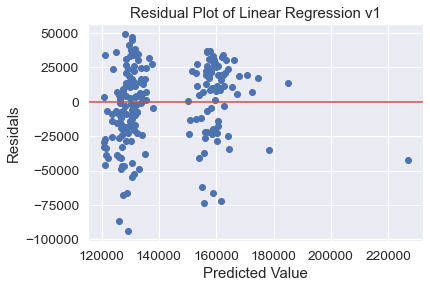

In [120]:
plot_residual(y_pred, y_dev)

In [122]:
#Model v1 Expensive Houses
initial_features = ['LotArea', 'BedroomAbvGr', 'FullBath']

X, y = exp_house_train[initial_features], exp_house_train['SalePrice']
X_train, X_dev, y_train, y_dev, y_pred, lr_model = evaluate_model(X, y, 'linear_regression', initial_model=True)

The initial model function is: y = 0.82x1 + -10466.33x2 + 72078.39x3 + 154659.16


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

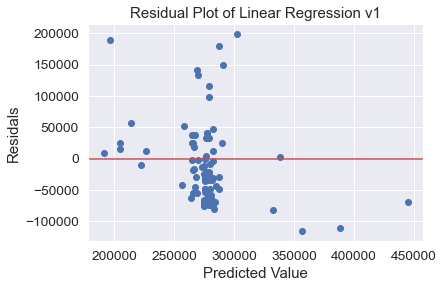

In [123]:
plot_residual(y_pred, y_dev)

In [148]:
#Model v2 Cheap Houses
X, y = cheap_house_train.drop('SalePrice', axis=1), cheap_house_train['SalePrice']
X_train, X_dev, y_train, y_dev, y_pred, lr_model = evaluate_model(X, y, 'linear_regression')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

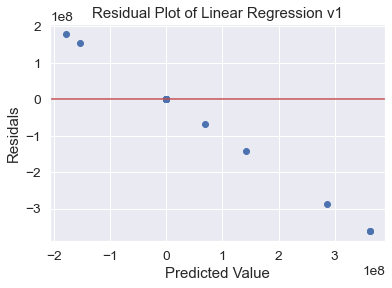

In [149]:
plot_residual(y_pred, y_dev)

In [150]:
#Model v2 Expensive Houses
X, y = exp_house_train.drop('SalePrice', axis=1), exp_house_train['SalePrice']
X_train, X_dev, y_train, y_dev, y_pred, lr_model = evaluate_model(X, y, 'linear_regression')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

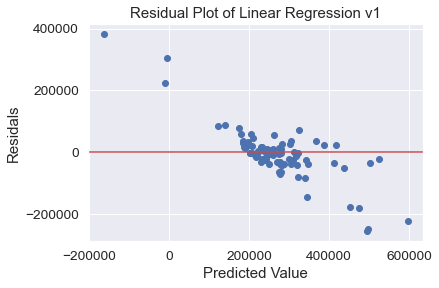

In [151]:
plot_residual(y_pred, y_dev)

### Split by LotArea - Small vs Big

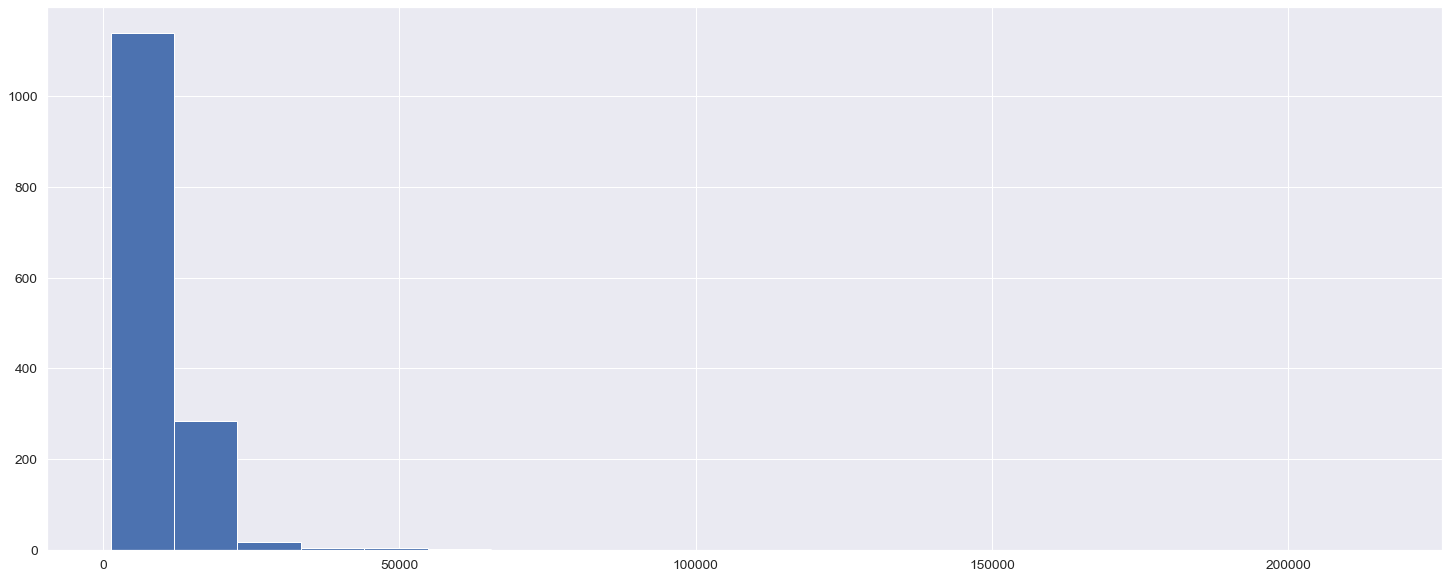

In [81]:
house_train['LotArea'].hist(bins=20, figsize=(25, 10))
plt.show()

In [82]:
house_train['LotArea'].describe()

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

In [83]:
small_lot_house_train = house_train[house_train['LotArea'] <= 10000]
large_lot_house_train = house_train[house_train['LotArea'] > 10000]

In [125]:
#Model v1 Small Lot
initial_features = ['LotArea', 'BedroomAbvGr', 'FullBath']

X, y = small_lot_house_train[initial_features], small_lot_house_train['SalePrice']
X_train, X_dev, y_train, y_dev, y_pred, lr_model = evaluate_model(X, y, 'linear_regression', initial_model=True)

The initial model function is: y = 5.73x1 + -3360.94x2 + 62533.32x3 + 30769.20


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

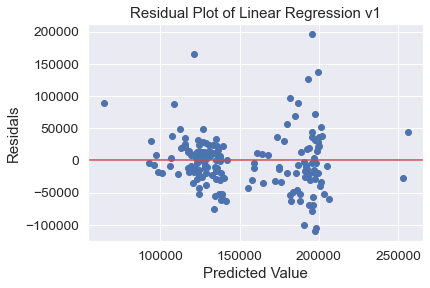

In [126]:
plot_residual(y_pred, y_dev)

In [127]:
#Model v1 Large Lot
initial_features = ['LotArea', 'BedroomAbvGr', 'FullBath']

X, y = large_lot_house_train[initial_features], large_lot_house_train['SalePrice']
X_train, X_dev, y_train, y_dev, y_pred, lr_model = evaluate_model(X, y, 'linear_regression', initial_model=True)

The initial model function is: y = 0.65x1 + -21899.70x2 + 96374.66x3 + 111093.85


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

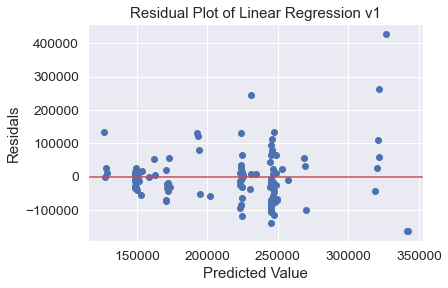

In [128]:
plot_residual(y_pred, y_dev)

In [152]:
#Model v2 Small Lot
X, y = small_lot_house_train.drop('SalePrice', axis=1), small_lot_house_train['SalePrice']
X_train, X_dev, y_train, y_dev, y_pred, lr_model = evaluate_model(X, y, 'linear_regression')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

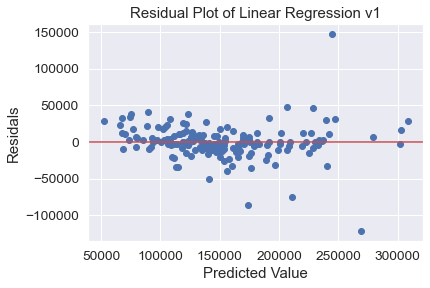

In [153]:
plot_residual(y_pred, y_dev)

In [154]:
#Model v2 Large Lot
X, y = large_lot_house_train.drop('SalePrice', axis=1), large_lot_house_train['SalePrice']
X_train, X_dev, y_train, y_dev, y_pred, lr_model = evaluate_model(X, y, 'linear_regression')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

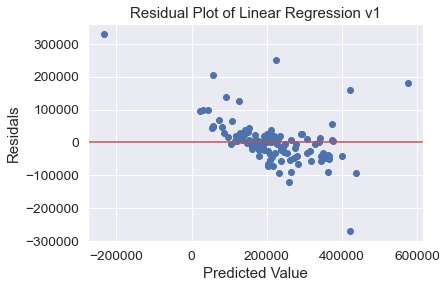

In [155]:
plot_residual(y_pred, y_dev)

### Split by YearBuilt - Old vs New

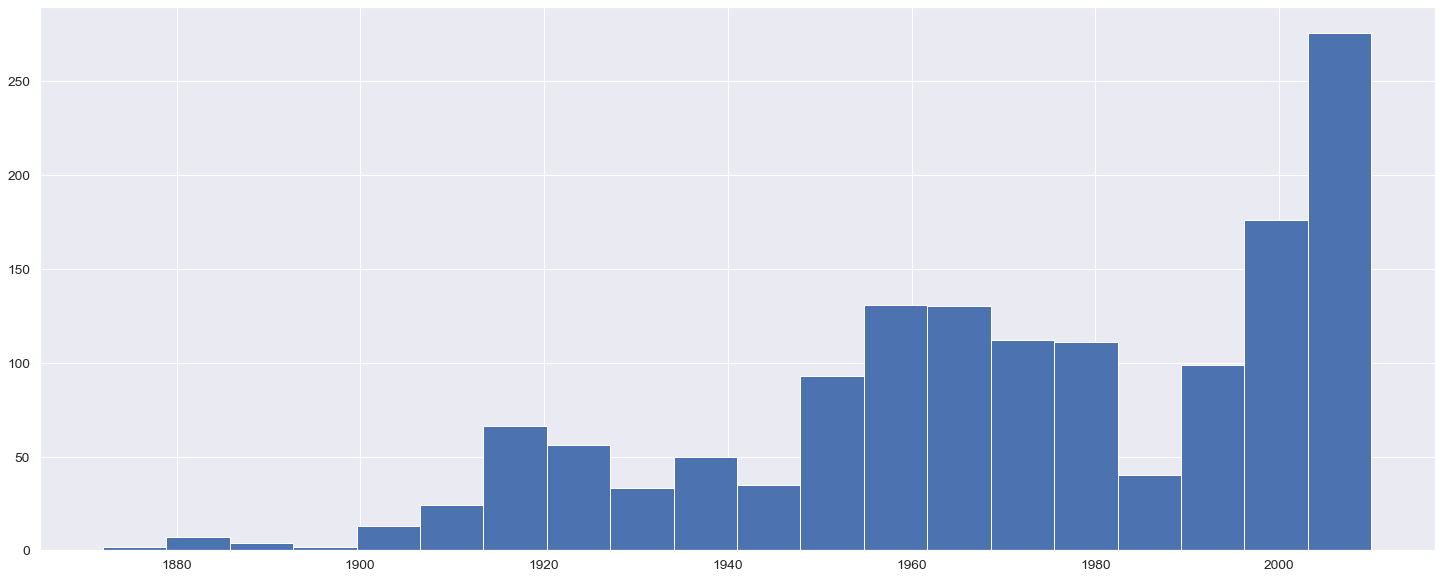

In [54]:
house_train['YearBuilt'].hist(bins=20, figsize=(25, 10))
plt.show()

In [55]:
house_train['YearBuilt'].describe()

count    1460.000000
mean     1971.267808
std        30.202904
min      1872.000000
25%      1954.000000
50%      1973.000000
75%      2000.000000
max      2010.000000
Name: YearBuilt, dtype: float64

In [88]:
old_house_train = house_train[house_train['YearBuilt'] <= 1990]
new_house_train = house_train[house_train['YearBuilt'] > 1990]

In [129]:
#Model v1 Old House
initial_features = ['LotArea', 'BedroomAbvGr', 'FullBath']

X, y = old_house_train[initial_features], old_house_train['SalePrice']
X_train, X_dev, y_train, y_dev, y_pred, lr_model = evaluate_model(X, y, 'linear_regression', initial_model=True)

The initial model function is: y = 1.49x1 + 6470.72x2 + 33499.98x3 + 67161.07


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

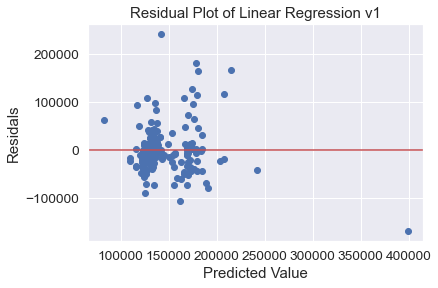

In [130]:
plot_residual(y_pred, y_dev)

In [116]:
#Model v1 New House
initial_features = ['LotArea', 'BedroomAbvGr', 'FullBath']

X, y = new_house_train[initial_features], new_house_train['SalePrice']
X_train, X_dev, y_train, y_dev, y_pred, lr_model = evaluate_model(X, y, 'linear_regression', initial_model=True)

The initial model function is: y = 5.80x1 + -10649.83x2 + 90734.36x3 + 35538.93


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

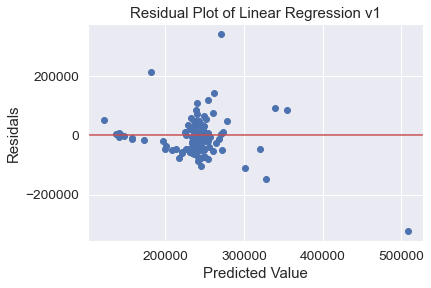

In [117]:
plot_residual(y_pred, y_dev)

In [156]:
#Model v2 Old House
X, y = old_house_train.drop('SalePrice', axis=1), old_house_train['SalePrice']
X_train, X_dev, y_train, y_dev, y_pred, lr_model = evaluate_model(X, y, 'linear_regression')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

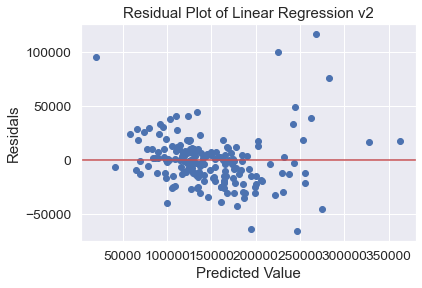

In [141]:
plot_residual(y_pred, y_dev, model_name = 'Linear Regression v2')

In [142]:
#Model v2 New House
X, y = new_house_train.drop('SalePrice', axis=1), new_house_train['SalePrice']
X_train, X_dev, y_train, y_dev, y_pred, lr_model = evaluate_model(X, y, 'linear_regression')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

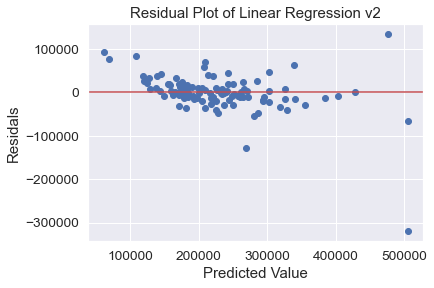

In [143]:
plot_residual(y_pred, y_dev, model_name = 'Linear Regression v2')